<a href="https://colab.research.google.com/github/jrmelog/ML-models-tracking/blob/main/Neptune_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion Mnist



## Install


In [1]:
! pip install neptune-client

     |████████████████████████████████| 316 kB 4.1 MB/s 
     |████████████████████████████████| 829 kB 50.2 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 181 kB 61.5 MB/s 
     |████████████████████████████████| 132 kB 50.6 MB/s 
     |████████████████████████████████| 8.7 MB 37.5 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 138 kB 58.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 127 kB 43.8 MB/s 
     |████████████████████████████████| 130 kB 50.4 MB/s 
     |████████████████████████████████| 67 kB 3.3 MB/s 
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.16.1-py2.py3-none-any.whl size=565960 sha256=7e94b777be2bb9d7fc135c025563fc0a5091b549526b8714a07b92bb008aa99b
  Stored in directory: /root/.cache/pip/wheels/8b/1a/02/10440cbdf7d5e3a3a13aab8ed77df

In [2]:
! pip install scikit-plot==0.3.7 tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 9.9 kB/s 
     |████████████████████████████████| 2.9 MB 27.1 MB/s 
     |████████████████████████████████| 462 kB 43.5 MB/s 
     |████████████████████████████████| 14.8 MB 877 kB/s 
     |████████████████████████████████| 3.8 MB 42.8 MB/s 
     |████████████████████████████████| 132 kB 41.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68724 sha256=bc37f74bf174a368051c6084e872dd2ead61128952c120ed7f2af4c8d27ba212
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting

## Imports

In [3]:
import neptune.new as neptune
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Execution

###Neptune Config

In [300]:
EPOCH_NR = 5
BATCH_SIZE = 32
learning_rate = 0.001

run = neptune.init(project="jrmelog/mnist", api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJlMmNkYjZjZS0yMjBmLTQxZjktOGM4Yi03MmE4YzBjNjFjNzgifQ==")

# log params
run['parameters/learning_rate'] = learning_rate
run["parameters/epoch_nr"] = EPOCH_NR
run["parameters/batch_size"] = BATCH_SIZE
run["parameters/optimizer"] = "SGD"

# log name and append tag
run["sys/name"] = "mnist"
run["sys/tags"].add("Dataset100%")

https://app.neptune.ai/jrmelog/mnist/e/FAS-34
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [301]:
#To log metrics after every batch and epoch let's create `NeptuneLogger` callback:

from tensorflow.keras.callbacks import Callback


class NeptuneLogger(Callback):
    def on_batch_end(self, batch, logs={}):
        for log_name, log_value in logs.items():
            run["batch/{}".format(log_name)].log(log_value)

    def on_epoch_end(self, epoch, logs={}):
        for log_name, log_value in logs.items():
            run["epoch/{}".format(log_name)].log(log_value)

##Modelo Keras

In [302]:
#fashion_mnist = tf.keras.datasets.fashion_mnist

#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

In [303]:
x_train = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/x_train_all.pkl")
y_train = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/y_train_all.pkl")

x_test = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/x_test_all.pkl")
y_test = pd.read_pickle("/content/drive/MyDrive/IARIS/Workflow/data/y_test_all.pkl")

### Download Pickle

In [304]:
#pd.to_pickle(x_train, "/content/x_train_all.pkl")
#pd.to_pickle(y_train, "/content/y_train_all.pkl")

#pd.to_pickle(x_test, "/content/x_test_all.pkl")
#pd.to_pickle(y_test, "/content/y_test_all.pkl")

In [305]:
#x_train_half = x_train[30000:]
#y_train_half = y_train[30000:]

#x_test_half = x_test[5000:]
#y_test_half = y_test[5000:]

In [306]:
#pd.to_pickle(x_train_half, "/content/x_train_half.pkl")
#pd.to_pickle(y_train_half, "/content/y_train_half.pkl")

#pd.to_pickle(x_test_half, "/content/x_test_half.pkl")
#pd.to_pickle(y_test_half, "/content/y_test_half.pkl")

In [307]:
y_train.shape

(60000,)

In [308]:
y_test.shape

(10000,)

###Model Config

In [309]:
SGD = tf.keras.optimizers.SGD(
    learning_rate, momentum=0.0, nesterov=False, name="SGD")

Adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [310]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

model.compile(
    optimizer=SGD, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

Now we simply need to create a run.
I will tag it with the name `advanced` and log hyperparameters `epoch_nr` and `batch_size`: 

Now we pass our `NeptuneLogger` as keras callback and thats it.

In [311]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCH_NR,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    callbacks=[NeptuneLogger()],
)

Epoch 1/5
1875/1875 [==============================] - 14s 7ms/step - loss: 1.6496 - accuracy: 0.4764 - val_loss: 0.9449 - val_accuracy: 0.7045
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.9053 - accuracy: 0.7129 - val_loss: 0.7783 - val_accuracy: 0.7485
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.7702 - accuracy: 0.7536 - val_loss: 0.7050 - val_accuracy: 0.7737
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6980 - accuracy: 0.7741 - val_loss: 0.6601 - val_accuracy: 0.7888
Epoch 5/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.6550 - accuracy: 0.7863 - val_loss: 0.6288 - val_accuracy: 0.7964


In [312]:
import numpy as np

y_test_pred = np.asarray(model.predict(x_test))
y_test_pred_class = np.argmax(y_test_pred, axis=1)

In [313]:
from sklearn.metrics import f1_score

run["test/f1"] = f1_score(y_test, y_test_pred_class, average="micro")

We can log diagnostic charts like confusion matrix or ROC AUC curve.

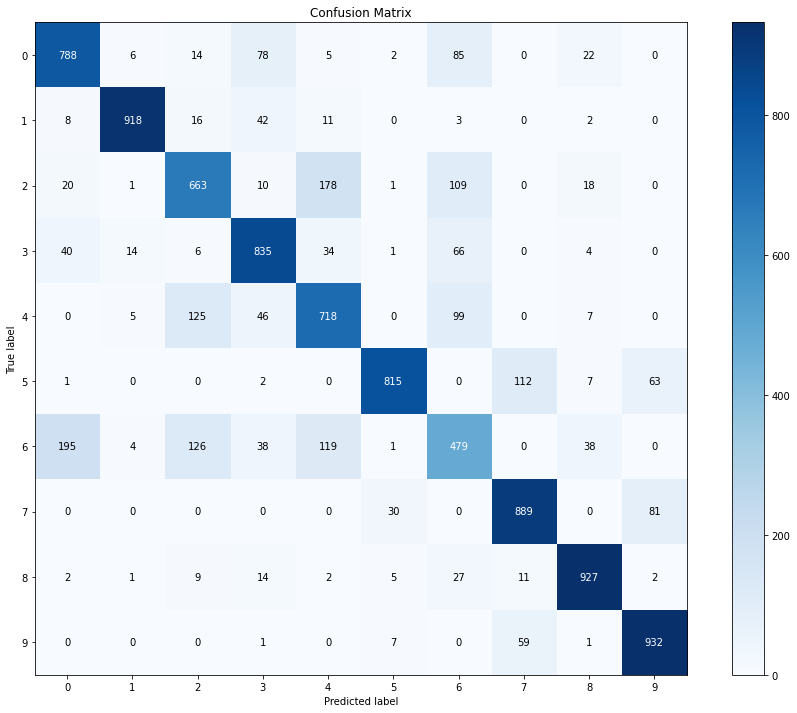

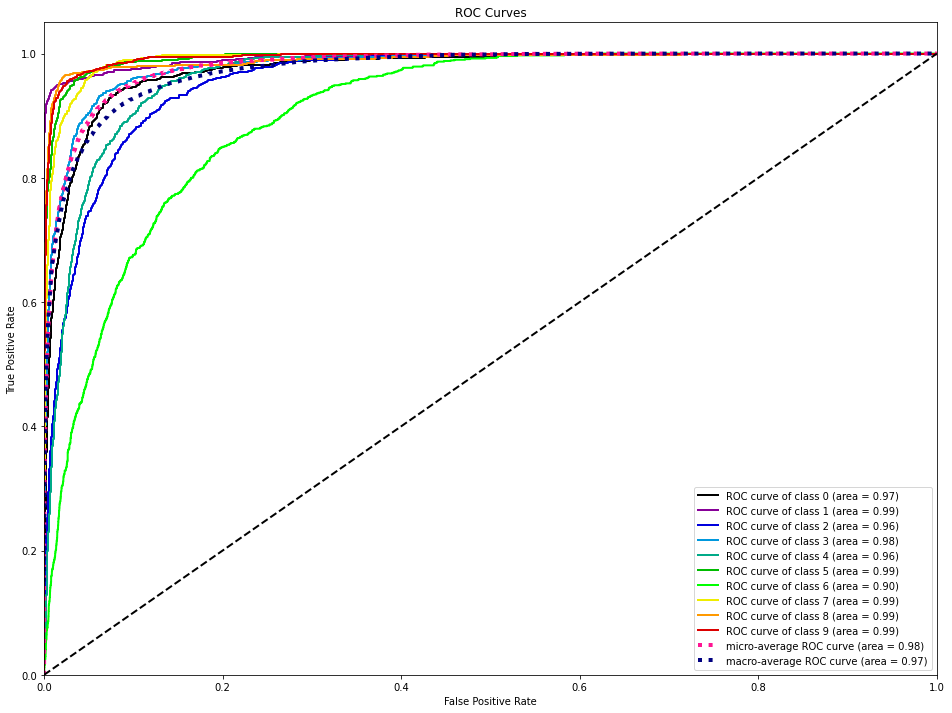

In [314]:
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix, plot_roc

fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(y_test, y_test_pred_class, ax=ax)
run["diagnostic_charts"].log(neptune.types.File.as_image(fig))

fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(y_test, y_test_pred, ax=ax)
run["diagnostic_charts"].log(neptune.types.File.as_image(fig))

In [315]:
model.save("my_model.h5")
run["model"].upload("my_model.h5")

**Stop logging** 

<font color=red>**Warning:**</font><br>
Once you are done logging, you should stop tracking the run using the `stop()` method.
This is needed only while logging from a notebook environment. While logging through a script, Neptune automatically stops tracking once the script has completed execution.

In [316]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.


All 15 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/jrmelog/mnist/e/FAS-34


#Outros

## Modelo Kaggle  

[Referência](https://www.kaggle.com/code/mehrdadsadeghi/fashionmnist-cnn-with-tensorflow-confusionmatrix)

###Download dataset

In [37]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [50]:
!kaggle datasets download -d zalando-research/fashionmnist

fashionmnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [51]:
!unzip fashionmnist.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
replace t10k-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: t10k-images-idx3-ubyte  
replace t10k-labels-idx1-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: t10k-labels-idx1-ubyte  
replace train-images-idx3-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-images-idx3-ubyte  
replace train-labels-idx1-ubyte? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train-labels-idx1-ubyte  


In [41]:
train = pd.read_csv('/content/fashion-mnist_train.csv')
test = pd.read_csv('/content/fashion-mnist_test.csv')

#store first column as target vector
train_labels = np.array(train.label)
test_labels = np.array(test.label)

train.drop('label',axis=1, inplace=True)
test.drop('label',axis=1, inplace=True)

#Reshape - adding one more dimension to each image
train_data = np.array(train).reshape(train.shape[0],28,28,1)
test_data = np.array(test).reshape(test.shape[0],28,28,1)

#Print shapes
print('Train tensor shape: ',train_data.shape)
print('Test tensor shape: ',test_data.shape)
print('Single image shape:', train_data[0].shape)
print('Train_labels shape:', train_labels.shape)
print('Test_labels shape:', test_labels.shape)

label_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Normalize
train_norm = train_data / 255.0
test_norm = test_data / 255.0

Train tensor shape:  (60000, 28, 28, 1)
Test tensor shape:  (10000, 28, 28, 1)
Single image shape: (28, 28, 1)
Train_labels shape: (60000,)
Test_labels shape: (10000,)


In [42]:
#Split the data
X_train = train_norm[10000:]
y_train = train_labels[10000:]

X_valid = train_norm[:10000]
y_valid = train_labels[:10000]

### DVC Config

[Referência](https://colab.research.google.com/github/khuyentran1401/Efficient_Python_tricks_and_tools_for_data_scientists/blob/master/Chapter5/manage_data.ipynb#scrollTo=dfb6b5cf)

In [44]:
!pip install dvc

     |████████████████████████████████| 400 kB 4.4 MB/s 
     |████████████████████████████████| 40 kB 5.2 MB/s 
     |████████████████████████████████| 232 kB 33.3 MB/s 
     |████████████████████████████████| 41 kB 249 kB/s 
     |████████████████████████████████| 44 kB 2.7 MB/s 
     |████████████████████████████████| 136 kB 30.8 MB/s 
     |████████████████████████████████| 280 kB 17.5 MB/s 
     |████████████████████████████████| 109 kB 60.9 MB/s 
     |████████████████████████████████| 551 kB 42.3 MB/s 
     |████████████████████████████████| 335 kB 42.3 MB/s 
     |████████████████████████████████| 4.5 MB 22.5 MB/s 
     |████████████████████████████████| 1.1 MB 50.4 MB/s 
     |████████████████████████████████| 4.0 MB 36.7 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 2.6 MB 27.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 596 kB 23.2 MB/s 
     |███████████████████

In [48]:
!cd fashion_mnist

In [49]:
!dvc init

ERROR: failed to initiate DVC - /content is not tracked by any supported SCM tool (e.g. Git). Use `--no-scm` if you don't want to use any SCM or `--subdir` if initializing inside a subdirectory of a parent SCM repository.


###Create Model

In [36]:
#Set random seed
tf.random.set_seed(42)

#Create model
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, padding="same", activation="relu",
                           input_shape=(28,28,1)), 
    tf.keras.layers.Conv2D(10,3, padding="valid", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(15,3, padding="valid", activation='relu'),
    tf.keras.layers.Conv2D(20,3, padding="valid", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(25,3, padding="valid", activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax") #Output layer

])

#Compile the model
model.compile(loss="sparse_categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
               metrics=["accuracy"])

#Show summary
model.summary()

#Fit the model
#history = model.fit(X_train, y_train,
#                    epochs=EPOCH_NR,batch_size=BATCH_SIZE,
#                    validation_data=(X_valid,y_valid), verbose=1
#                    )

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCH_NR,
    batch_size=BATCH_SIZE,
    validation_data=(X_valid, y_valid),
    callbacks=[NeptuneLogger()],
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 10)        460       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 10)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 15)        1365      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 9, 9, 20)          2720      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 4, 4, 20)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 2, 2, 25)         

### Train/Validation Results

In [ ]:
pd.DataFrame(history.history).plot(title="Train and validation results",figsize=(10,7));

###Evaluating model on test data

In [29]:
loss, accuracy = model.evaluate(test_norm, test_labels)
print('Test accuracy:' , accuracy * 100,'%')

313/313 [==============================] - 9s 27ms/step - loss: 0.3882 - accuracy: 0.8599
Test accuracy: 85.98999977111816 %


###Confusion matrix

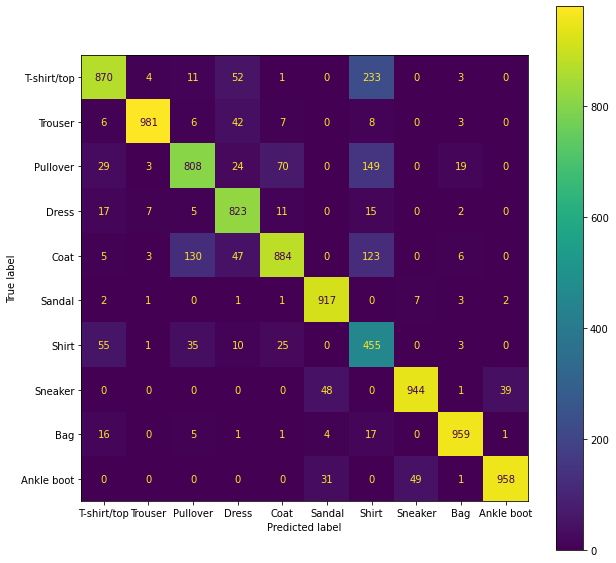

In [31]:
#Make predictions
y_probs = model.predict(test_norm)

#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)

cm=confusion_matrix(y_preds,test_labels)
#Plot
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax);

## Access data you logged programatically 

## Getting the project's leaderboard

You can use the Project object to get aggregate data of all your runs. Here, fetch only runs with tag 'advanced'.

In [ ]:
my_project = neptune.get_project(name="common/colab-test-run", api_token="ANONYMOUS")
run_df = my_project.fetch_runs_table(tag=["advanced"]).to_pandas()
run_df.head()

## Getting the run's metadata

Neptune lets you fetch whatever you logged to it directly to your notebooks and scripts.

In [ ]:
run = neptune.init(project="common/colab-test-run", api_token="ANONYMOUS", run="COL-7")

Now that your run is *fetched* you can download the metadata.

In [ ]:
batch_size = run["parameters/batch_size"].fetch()
last_batch_acc = run["batch/accuracy"].fetch_last()
print("batch_size: {}".format(batch_size))
print("last_batch_acc: {}".format(last_batch_acc))

You can even download artifacts from that run if you want to:



In [ ]:
run["model"].download()

In [ ]:
! ls ./